In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

--------
# Gather data

In [3]:
zbest_path = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits'
zbest_columns = ['TARGETID', 'CHI2', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'GAIA_PHOT_G_MEAN_MAG', 'EBV', 'FLUX_W1', 'FLUX_W2', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'TILEID', 'COADD_NUMEXP', 'COADD_EXPTIME', 'EXPS', 'TSNR2_ELG', 'TSNR2_BGS', 'TSNR2_QSO', 'TSNR2_LRG', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACK', 'coadd_type', 'TARGETS', 'FIRST_EXPID', 'subset']

tmp = Table(fitsio.read(zbest_path, columns=['SV1_DESI_TARGET', 'TARGETS', 'coadd_type']))
mask = (tmp['SV1_DESI_TARGET'] & 2**0 > 0) & (tmp['TARGETS']=='QSO+LRG') & (tmp['coadd_type']!='pernight')
idx = np.where(mask)[0]

zbest = Table(fitsio.read(zbest_path, columns=zbest_columns, rows=idx))
print(len(zbest))
print(len(np.unique(zbest['TARGETID'])))

581288
52023


In [4]:
deep = zbest.copy()

# Select deep coadds
mask = deep['coadd_type']=='cumulative'
print(np.sum(mask))
# # Select QSO+LRG tiles
# mask &= deep['TARGETS']=='QSO+LRG'
# print(np.sum(mask))
deep = deep[mask]

# Remove FIBERSTATUS!=0 fibers
mask = deep['FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
deep = deep[mask]

# Remove "no data" fibers
mask = deep['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
deep = deep[mask]

# Require a minimum depth for the deep coadd
min_depth = 3000.
mask = deep['EFFTIME_DARK']>min_depth
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
deep = deep[mask]

# WISE masks
maskbits = [8]
mask_quality = np.ones(len(deep), dtype=bool)
for bit in maskbits:
    mask_quality &= (deep['MASKBITS'] & 2**bit)==0
print('MASKBITS', np.sum(mask_quality), np.sum(~mask_quality), np.sum(mask_quality)/len(mask_quality))
deep = deep[mask_quality]

52268
FIBERSTATUS 43371 8897 0.17021887196755184
No data 43368 3 6.917064397869545e-05
Min depth 31466 11902 0.7255580151263604
MASKBITS 30260 1206 0.9616729167990847


In [5]:
print(len(deep))
print(len(np.unique(deep['TARGETID'])))

deep_columns_old = ['Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACK']
deep_columns_new = ['Z_deep', 'ZERR_deep', 'ZWARN_deep', 'SPECTYPE_deep', 'SUBTYPE_deep', 'DELTACHI2_deep', 'EFFTIME_DARK_deep', 'EFFTIME_BRIGHT_deep', 'EFFTIME_BACK_deep']
deep.rename_columns(deep_columns_old, deep_columns_new)

30260
30203


In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    deep['gmag'] = 22.5 - 2.5*np.log10(deep['FLUX_G']) - 3.214 * deep['EBV']
    deep['rmag'] = 22.5 - 2.5*np.log10(deep['FLUX_R']) - 2.165 * deep['EBV']
    deep['zmag'] = 22.5 - 2.5*np.log10(deep['FLUX_Z']) - 1.211 * deep['EBV']
    deep['w1mag'] = 22.5 - 2.5*np.log10(deep['FLUX_W1']) - 0.184 * deep['EBV']
    deep['w2mag'] = 22.5 - 2.5*np.log10(deep['FLUX_W2']) - 0.113 * deep['EBV']
    deep['rfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_R']) - 2.165 * deep['EBV']
    deep['zfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_Z']) - 1.211 * deep['EBV']

In [7]:
mask = zbest['coadd_type']=='perexp'
zbest = zbest[mask]
print(len(zbest))

zbest['EXPID'] = np.array(np.char.replace(zbest['subset'], 'exp', ''), dtype=int)

mask = np.in1d(zbest['TARGETID'], deep['TARGETID'])
zbest = zbest[mask]
print(len(zbest))

print(len(np.unique(zbest['TARGETID'])))

deep_columns = deep_columns_new+['TARGETID', 'gmag', 'rmag', 'zmag', 'w1mag', 'w2mag', 'rfibermag', 'zfibermag']
zbest = join(zbest, deep[deep_columns], keys='TARGETID')

529020
376071
30203


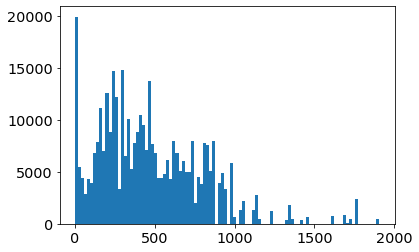

21775 0.057718967605809274


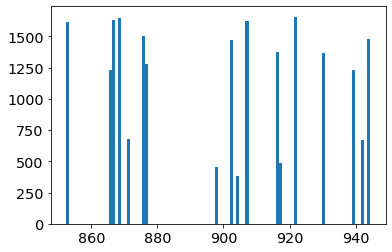

898.0107821553665
902.4139404296875


In [8]:
plt.hist(zbest['EFFTIME_DARK'], 100)
plt.show()

mask = (zbest['EFFTIME_DARK'] > 850) & (zbest['EFFTIME_DARK'] < 950)
print(np.sum(mask), np.sum(mask)/len(mask))

zbest = zbest[mask]

plt.hist(zbest['EFFTIME_DARK'], 100)
plt.show()

print(np.mean(zbest['EFFTIME_DARK']))
print(np.median(zbest['EFFTIME_DARK']))

-------
# Apply SV3 selection

In [9]:
gmag = zbest['gmag']
rmag = zbest['rmag']
zmag = zbest['zmag']
w1mag = zbest['w1mag']
w2mag = zbest['w2mag']
rfibermag = zbest['rfibermag']
zfibermag = zbest['zfibermag']
gaia_g = zbest['GAIA_PHOT_G_MEAN_MAG']

mask_north = zbest['PHOTSYS']=='N'
mask_south = zbest['PHOTSYS']=='S'

In [10]:
# zfiber & sliding cut extension; 800 targets/sq.deg.

# South
lrg_mask = mask_south.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.7)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.26) * 1.8 # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.36) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.29
lrg_mask &= lrg_mask_sliding

mask_lowz = (gmag - rmag > 1.3) & ( (gmag - rmag) > -1.55 * (rmag - w1mag) + 3.13)
mask_lowz |= (rmag - w1mag > 1.8)
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_sv3_south = lrg_mask.copy()

# North
lrg_mask = mask_north.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.72)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.24) * 1.83 # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.39
lrg_mask &= lrg_mask_sliding

mask_lowz = (gmag - rmag > 1.34) & ( (gmag - rmag) > -1.55 * (rmag - w1mag) + 3.23)
mask_lowz |= (rmag - w1mag > 1.8)
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_sv3_north = lrg_mask.copy()

lrg_sv3 = lrg_sv3_south | lrg_sv3_north
print(np.sum(lrg_sv3))

7957


In [11]:
lrg_sv3_216 = lrg_sv3 & (zbest['zfibermag']<21.6)
lrg_sv3_215 = lrg_sv3 & (zbest['zfibermag']<21.5)
print(np.sum(lrg_sv3_216))
print(np.sum(lrg_sv3_215))

7047
6297


----------

In [12]:
# Not repeatable
zdiff_threshold = 0.0033
mask_fail = np.abs((zbest['Z'] - zbest['Z_deep'])/(1 + zbest['Z_deep'])) > zdiff_threshold
print(np.sum(mask_fail), np.sum(mask_fail)/len(mask_fail))
# Also include objects with ZWARN!=0 and z<1.4 in the deep coadds
mask_deep = (zbest['ZWARN_deep']==0) & (zbest['Z_deep']<1.4)
# mask_deep = (zbest['ZWARN_deep']==0) & (zbest['Z_deep']<1.4) & (zbest['DELTACHI2_deep']>30)
mask_fail |= (~mask_deep)
print(np.sum(mask_fail), np.sum(mask_fail)/len(mask_fail))

1997 0.09171067738231917
2098 0.09634902411021815


In [13]:
inclass = (zbest['Z']>0.3) & (zbest['Z']<1.4)

mask_quality = zbest['ZWARN']==0
mask_quality &= zbest['Z']<1.4
mask_quality &= zbest['DELTACHI2']>15

d = (10**(3 - 3.5*zbest['Z']))
mask_remove = (d>20) & (zbest['DELTACHI2']<20)
mask_remove |= (d<20) & (zbest['DELTACHI2']<d)
mask_remove |= (zbest['DELTACHI2']<9)
mask_quality1 = zbest['ZWARN']==0
mask_quality1 &= zbest['Z']<1.4
mask_quality1 &= (~mask_remove)

In [14]:
print('Overall failure rates (no quality cut):')
print('zfiber<21.7: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3 & mask_fail)/np.sum(lrg_sv3)*100, np.sum(lrg_sv3 & mask_fail), np.sum(lrg_sv3)))
print('zfiber<21.6: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_216 & mask_fail)/np.sum(lrg_sv3_216)*100, np.sum(lrg_sv3_216 & mask_fail), np.sum(lrg_sv3_216)))
print('zfiber<21.5: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_215 & mask_fail)/np.sum(lrg_sv3_215)*100, np.sum(lrg_sv3_215 & mask_fail), np.sum(lrg_sv3_215)))

Overall failure rates (no quality cut):
zfiber<21.7: 4.3% (344/7957)
zfiber<21.6: 3.2% (228/7047)
zfiber<21.5: 2.9% (180/6297)


In [15]:
print('Targeting completeness:')
print('zfiber<21.7: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3 & inclass)/np.sum(lrg_sv3)*100, np.sum(lrg_sv3 & inclass), np.sum(lrg_sv3)))
print('zfiber<21.6: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_216 & inclass)/np.sum(lrg_sv3_216)*100, np.sum(lrg_sv3_216 & inclass), np.sum(lrg_sv3_216)))
print('zfiber<21.5: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_215 & inclass)/np.sum(lrg_sv3_215)*100, np.sum(lrg_sv3_215 & inclass), np.sum(lrg_sv3_215)))
print()

print('Redshift completeness:')
print('zfiber<21.7: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3 & inclass & mask_quality & (~mask_fail))/np.sum(lrg_sv3 & inclass)*100, np.sum(lrg_sv3 & inclass & mask_quality & (~mask_fail)), np.sum(lrg_sv3 & inclass)))
print('zfiber<21.6: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_216 & inclass & mask_quality & (~mask_fail))/np.sum(lrg_sv3_216 & inclass)*100, np.sum(lrg_sv3_216 & inclass & mask_quality & (~mask_fail)), np.sum(lrg_sv3_216 & inclass)))
print('zfiber<21.5: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_215 & inclass & mask_quality & (~mask_fail))/np.sum(lrg_sv3_215 & inclass)*100, np.sum(lrg_sv3_215 & inclass & mask_quality & (~mask_fail)), np.sum(lrg_sv3_215 & inclass)))
print()

print('Catastrophic failures:')
print('zfiber<21.7: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3 & inclass & mask_quality & mask_fail)/np.sum(lrg_sv3 & inclass)*100, np.sum(lrg_sv3 & inclass & mask_quality & mask_fail), np.sum(lrg_sv3 & inclass)))
print('zfiber<21.6: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_216 & inclass & mask_quality & mask_fail)/np.sum(lrg_sv3_216 & inclass)*100, np.sum(lrg_sv3_216 & inclass & mask_quality & mask_fail), np.sum(lrg_sv3_216 & inclass)))
print('zfiber<21.5: {:.1f}% ({}/{})'.format(np.sum(lrg_sv3_215 & inclass & mask_quality & mask_fail)/np.sum(lrg_sv3_215 & inclass)*100, np.sum(lrg_sv3_215 & inclass & mask_quality & mask_fail), np.sum(lrg_sv3_215 & inclass)))
print()

Targeting completeness:
zfiber<21.7: 95.8% (7621/7957)
zfiber<21.6: 96.0% (6764/7047)
zfiber<21.5: 95.9% (6036/6297)

Redshift completeness:
zfiber<21.7: 94.4% (7194/7621)
zfiber<21.6: 96.4% (6518/6764)
zfiber<21.5: 97.3% (5873/6036)

Catastrophic failures:
zfiber<21.7: 1.1% (81/7621)
zfiber<21.6: 1.0% (65/6764)
zfiber<21.5: 0.9% (52/6036)



-------
# SV3 selection

[17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7
 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1
 20.2 20.3 20.4 20.5 20.6 20.7 20.8 20.9 21.  21.1 21.2 21.3 21.4 21.5
 21.6 21.7 21.8 21.9 22. ]


<ipython-input-16-310dd71a78ff>:9: RuntimeWarning: invalid value encountered in true_divide
  n, p_complete = n_correct_z, n_correct_z/n_in_class
<ipython-input-16-310dd71a78ff>:10: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.maximum(p_complete, 1/n)  # error floor
<ipython-input-16-310dd71a78ff>:11: RuntimeWarning: invalid value encountered in true_divide
  errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
<ipython-input-16-310dd71a78ff>:11: RuntimeWarning: invalid value encountered in multiply
  errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
<ipython-input-16-310dd71a78ff>:13: RuntimeWarning: invalid value encountered in true_divide
  n, p_fail = n_fail, n_fail/n_in_class
<ipython-input-16-310dd71a78ff>:14: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.maximum(p_fail, 1/n)  # error floor


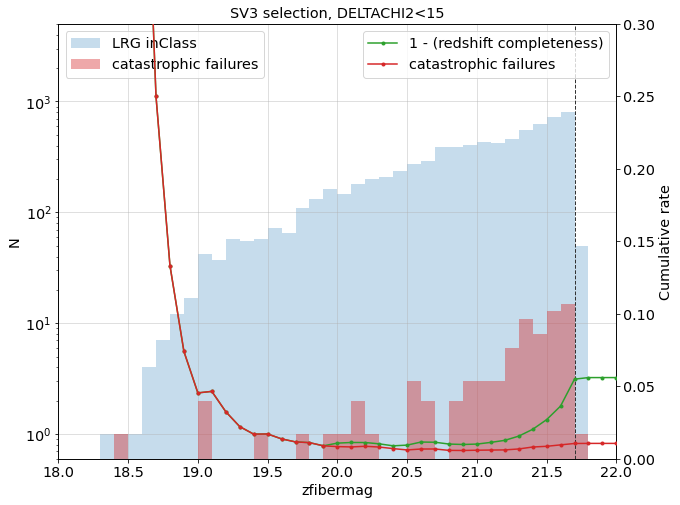

In [16]:
bins = np.linspace(17.4, 22., 47)
print(bins)
bin_upper_edges = bins[1:]

n_in_class = np.cumsum(np.histogram(zbest['zfibermag'][lrg_sv3 & inclass], bins=bins)[0])
n_correct_z = np.cumsum(np.histogram(zbest['zfibermag'][lrg_sv3 & inclass & mask_quality & (~mask_fail)], bins=bins)[0])
n_fail = np.cumsum(np.histogram(zbest['zfibermag'][lrg_sv3 & inclass & mask_quality & mask_fail], bins=bins)[0])

n, p_complete = n_correct_z, n_correct_z/n_in_class
p1 = np.maximum(p_complete, 1/n)  # error floor
errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

n, p_fail = n_fail, n_fail/n_in_class
p1 = np.maximum(p_fail, 1/n)  # error floor
errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.hist(zbest['zfibermag'][lrg_sv3 & inclass], bins=bins, alpha=0.25, label='LRG inClass', zorder=1, log=True)
ax1.hist(zbest['zfibermag'][lrg_sv3 & inclass & mask_quality & mask_fail], bins=bins, alpha=0.4, label='catastrophic failures', zorder=2, color='C3')
ax1.set_xlabel('zfibermag')
ax1.set_ylabel('N')
ax1.set_title('SV3 selection, DELTACHI2<15')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.5)
ax1.set_ylim(0.6, 5e3)
ax2 = ax1.twinx()
ax2.plot(bin_upper_edges, 1-p_complete, '.-', label='1 - (redshift completeness)', zorder=3, color='C2')
ax2.plot(bin_upper_edges, p_fail, '.-', label='catastrophic failures', zorder=3, color='C3')
ax2.axvline(21.7, ls='--', lw=1, color='0.2')
ax2.set_xlabel('zfibermag')
ax2.set_ylabel('Cumulative rate')
ax2.set_xlim(18, 22)
ax2.set_ylim(0, 0.3)
ax2.legend(loc='upper right')
plt.show()

[17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7
 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1
 20.2 20.3 20.4 20.5 20.6 20.7 20.8 20.9 21.  21.1 21.2 21.3 21.4 21.5
 21.6 21.7 21.8 21.9 22. ]


<ipython-input-17-4d89d9190f15>:9: RuntimeWarning: invalid value encountered in true_divide
  n, p_complete = n_correct_z, n_correct_z/n_in_class
<ipython-input-17-4d89d9190f15>:10: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.maximum(p_complete, 1/n)  # error floor
<ipython-input-17-4d89d9190f15>:11: RuntimeWarning: invalid value encountered in true_divide
  errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
<ipython-input-17-4d89d9190f15>:11: RuntimeWarning: invalid value encountered in multiply
  errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
<ipython-input-17-4d89d9190f15>:13: RuntimeWarning: invalid value encountered in true_divide
  n, p_fail = n_fail, n_fail/n_in_class
<ipython-input-17-4d89d9190f15>:14: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.maximum(p_fail, 1/n)  # error floor


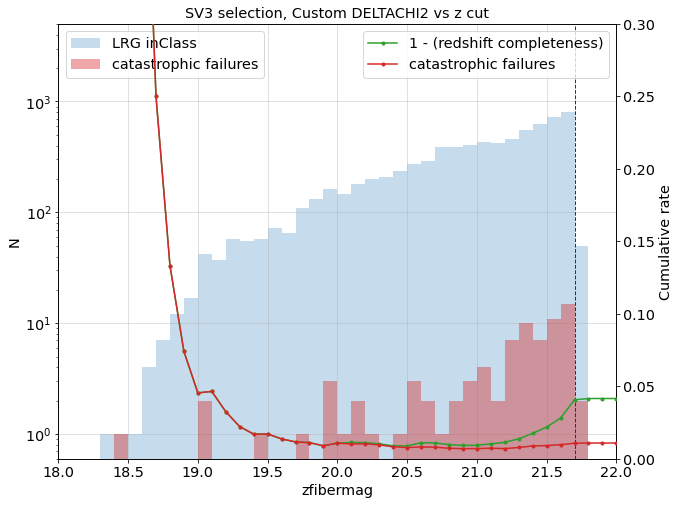

In [17]:
bins = np.linspace(17.4, 22., 47)
print(bins)
bin_upper_edges = bins[1:]

n_in_class = np.cumsum(np.histogram(zbest['zfibermag'][lrg_sv3 & inclass], bins=bins)[0])
n_correct_z = np.cumsum(np.histogram(zbest['zfibermag'][lrg_sv3 & inclass & mask_quality1 & (~mask_fail)], bins=bins)[0])
n_fail = np.cumsum(np.histogram(zbest['zfibermag'][lrg_sv3 & inclass & mask_quality1 & mask_fail], bins=bins)[0])

n, p_complete = n_correct_z, n_correct_z/n_in_class
p1 = np.maximum(p_complete, 1/n)  # error floor
errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

n, p_fail = n_fail, n_fail/n_in_class
p1 = np.maximum(p_fail, 1/n)  # error floor
errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.hist(zbest['zfibermag'][lrg_sv3 & inclass], bins=bins, alpha=0.25, label='LRG inClass', zorder=1, log=True)
ax1.hist(zbest['zfibermag'][lrg_sv3 & inclass & mask_quality1 & mask_fail], bins=bins, alpha=0.4, label='catastrophic failures', zorder=2, color='C3')
ax1.set_xlabel('zfibermag')
ax1.set_ylabel('N')
ax1.set_title('SV3 selection, Custom DELTACHI2 vs z cut')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.5)
ax1.set_ylim(0.6, 5e3)
ax2 = ax1.twinx()
ax2.plot(bin_upper_edges, 1-p_complete, '.-', label='1 - (redshift completeness)', zorder=3, color='C2')
ax2.plot(bin_upper_edges, p_fail, '.-', label='catastrophic failures', zorder=3, color='C3')
ax2.axvline(21.7, ls='--', lw=1, color='0.2')
ax2.set_xlabel('zfibermag')
ax2.set_ylabel('Cumulative rate')
ax2.set_xlim(18, 22)
ax2.set_ylim(0, 0.3)
ax2.legend(loc='upper right')
plt.show()

-------
# All SV LRGs

[17.4  17.45 17.5  17.55 17.6  17.65 17.7  17.75 17.8  17.85 17.9  17.95
 18.   18.05 18.1  18.15 18.2  18.25 18.3  18.35 18.4  18.45 18.5  18.55
 18.6  18.65 18.7  18.75 18.8  18.85 18.9  18.95 19.   19.05 19.1  19.15
 19.2  19.25 19.3  19.35 19.4  19.45 19.5  19.55 19.6  19.65 19.7  19.75
 19.8  19.85 19.9  19.95 20.   20.05 20.1  20.15 20.2  20.25 20.3  20.35
 20.4  20.45 20.5  20.55 20.6  20.65 20.7  20.75 20.8  20.85 20.9  20.95
 21.   21.05 21.1  21.15 21.2  21.25 21.3  21.35 21.4  21.45 21.5  21.55
 21.6  21.65 21.7  21.75 21.8  21.85 21.9  21.95 22.  ]


<ipython-input-20-180ab7150225>:14: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.maximum(p_fail, 1/n)  # error floor
<ipython-input-20-180ab7150225>:15: RuntimeWarning: invalid value encountered in true_divide
  errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
<ipython-input-20-180ab7150225>:15: RuntimeWarning: invalid value encountered in multiply
  errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)


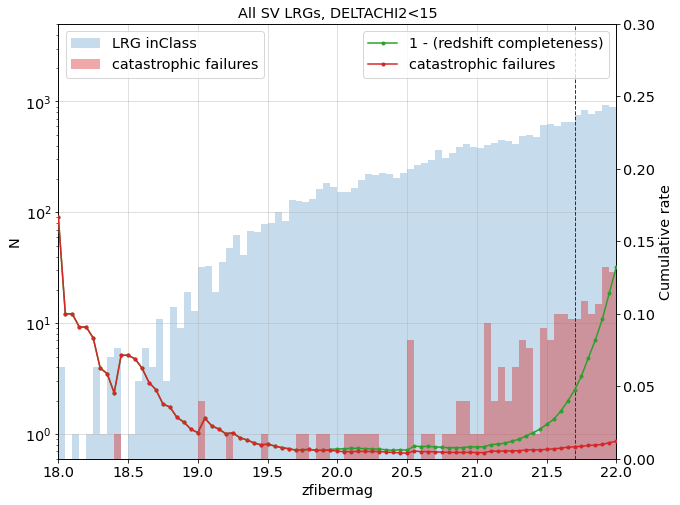

In [20]:
bins = np.linspace(17.4, 22., 93)
print(bins)
bin_upper_edges = bins[1:]

n_in_class = np.cumsum(np.histogram(zbest['zfibermag'][inclass], bins=bins)[0])
n_correct_z = np.cumsum(np.histogram(zbest['zfibermag'][inclass & mask_quality & (~mask_fail)], bins=bins)[0])
n_fail = np.cumsum(np.histogram(zbest['zfibermag'][inclass & mask_quality & mask_fail], bins=bins)[0])

n, p_complete = n_correct_z, n_correct_z/n_in_class
p1 = np.maximum(p_complete, 1/n)  # error floor
errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

n, p_fail = n_fail, n_fail/n_in_class
p1 = np.maximum(p_fail, 1/n)  # error floor
errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.hist(zbest['zfibermag'][inclass], bins=bins, alpha=0.25, label='LRG inClass', zorder=1, log=True)
ax1.hist(zbest['zfibermag'][inclass & mask_quality & mask_fail], bins=bins, alpha=0.4, label='catastrophic failures', zorder=2, color='C3')
ax1.set_xlabel('zfibermag')
ax1.set_ylabel('N')
ax1.set_title('All SV LRGs, DELTACHI2<15')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.5)
ax1.set_ylim(0.6, 5e3)
ax2 = ax1.twinx()
ax2.plot(bin_upper_edges, 1-p_complete, '.-', label='1 - (redshift completeness)', zorder=3, color='C2')
ax2.plot(bin_upper_edges, p_fail, '.-', label='catastrophic failures', zorder=3, color='C3')
ax2.axvline(21.7, ls='--', lw=1, color='0.2')
ax2.set_xlabel('zfibermag')
ax2.set_ylabel('Cumulative rate')
ax2.set_xlim(18, 22)
ax2.set_ylim(0, 0.3)
ax2.legend(loc='upper right')
plt.show()

[17.4  17.45 17.5  17.55 17.6  17.65 17.7  17.75 17.8  17.85 17.9  17.95
 18.   18.05 18.1  18.15 18.2  18.25 18.3  18.35 18.4  18.45 18.5  18.55
 18.6  18.65 18.7  18.75 18.8  18.85 18.9  18.95 19.   19.05 19.1  19.15
 19.2  19.25 19.3  19.35 19.4  19.45 19.5  19.55 19.6  19.65 19.7  19.75
 19.8  19.85 19.9  19.95 20.   20.05 20.1  20.15 20.2  20.25 20.3  20.35
 20.4  20.45 20.5  20.55 20.6  20.65 20.7  20.75 20.8  20.85 20.9  20.95
 21.   21.05 21.1  21.15 21.2  21.25 21.3  21.35 21.4  21.45 21.5  21.55
 21.6  21.65 21.7  21.75 21.8  21.85 21.9  21.95 22.  ]


<ipython-input-21-76cb060004c1>:14: RuntimeWarning: divide by zero encountered in true_divide
  p1 = np.maximum(p_fail, 1/n)  # error floor
<ipython-input-21-76cb060004c1>:15: RuntimeWarning: invalid value encountered in true_divide
  errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
<ipython-input-21-76cb060004c1>:15: RuntimeWarning: invalid value encountered in multiply
  errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)


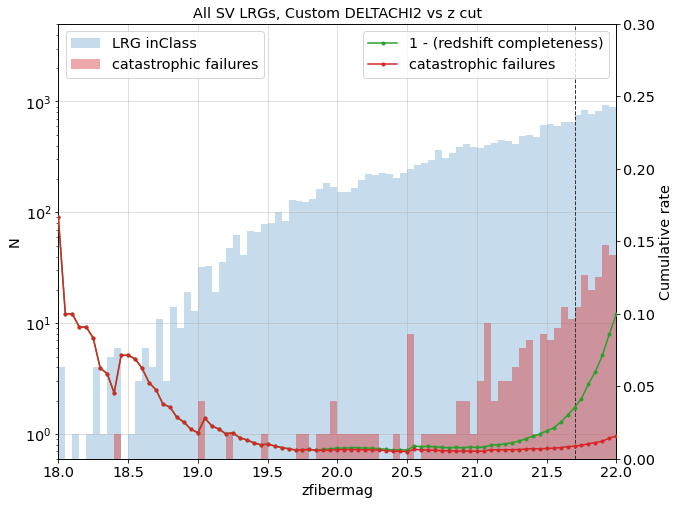

In [21]:
bins = np.linspace(17.4, 22., 93)
print(bins)
bin_upper_edges = bins[1:]

n_in_class = np.cumsum(np.histogram(zbest['zfibermag'][inclass], bins=bins)[0])
n_correct_z = np.cumsum(np.histogram(zbest['zfibermag'][inclass & mask_quality1 & (~mask_fail)], bins=bins)[0])
n_fail = np.cumsum(np.histogram(zbest['zfibermag'][inclass & mask_quality1 & mask_fail], bins=bins)[0])

n, p_complete = n_correct_z, n_correct_z/n_in_class
p1 = np.maximum(p_complete, 1/n)  # error floor
errors_complete = np.clip(np.sqrt(n * p_complete * (1-p_complete))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

n, p_fail = n_fail, n_fail/n_in_class
p1 = np.maximum(p_fail, 1/n)  # error floor
errors_fail = np.clip(np.sqrt(n * p_fail * (1-p_fail))/n, np.sqrt(n * p1 * (1-p1))/n, 1)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.hist(zbest['zfibermag'][inclass], bins=bins, alpha=0.25, label='LRG inClass', zorder=1, log=True)
ax1.hist(zbest['zfibermag'][inclass & mask_quality1 & mask_fail], bins=bins, alpha=0.4, label='catastrophic failures', zorder=2, color='C3')
ax1.set_xlabel('zfibermag')
ax1.set_ylabel('N')
ax1.set_title('All SV LRGs, Custom DELTACHI2 vs z cut')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.5)
ax1.set_ylim(0.6, 5e3)
ax2 = ax1.twinx()
ax2.plot(bin_upper_edges, 1-p_complete, '.-', label='1 - (redshift completeness)', zorder=3, color='C2')
ax2.plot(bin_upper_edges, p_fail, '.-', label='catastrophic failures', zorder=3, color='C3')
ax2.axvline(21.7, ls='--', lw=1, color='0.2')
ax2.set_xlabel('zfibermag')
ax2.set_ylabel('Cumulative rate')
ax2.set_xlim(18, 22)
ax2.set_ylim(0, 0.3)
ax2.legend(loc='upper right')
plt.show()